[View in Colaboratory](https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/src/Transfer_Learning_Clean_Up_N/F.ipynb)

In [1]:
# Import necessary modules

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wf
import time
import glob
import datetime

from tqdm import trange

# Import Keras modules

from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model


Using TensorFlow backend.


In [2]:
# Mount google drive

from google.colab import drive
drive.mount('/content/gdrive')
os.listdir('gdrive/My Drive/Colab')

Mounted at /content/gdrive


['Data_', 'Model', 'Data']

In [0]:
# Set data directories

dataPath = 'gdrive/My Drive/Colab/Data'

# Changed variable names to normal and fault
# Changed variable names from folder to path
# Need to consider multiple folders
# Need to add files to be tested

folderNormal = ['A1F1P1', 'A2F1P1', 'A1F2P1', 'A1F1P2', 'A2F2P1', 'A1F2P2', 'A2F1P2', 'A2F2P2']

folderFault = list()

for x in range(1, 6):
    for y in range(1, 6):
        for z in range(1, 6):
            if (x == 5 or y == 5 or z == 5):
                folderFault.append('A{}F{}P{}'.format(x, y, z))

pathNormal = list()
pathFault = list()

for i in range(len(folderNormal)):
    pathNormal.append(dataPath + '/' + folderNormal[i])
    
for i in range(len(folderFault)):
    pathFault.append(dataPath + '/' + folderFault[i])

normIdx = list()
faultIdx = list()
filesNormal = list()
filesFault = list()

for i in range(len(pathNormal)):
    filesNormalTemp = os.listdir(pathNormal[i])
    filesNormalTemp = [file for file in filesNormalTemp if file.endswith('.wav')]
    
    randIdx = np.random.choice(range(1000), round(1000/len(pathNormal)), replace=False)
    randIdx.sort()
    normIdx.append(randIdx)
    
    filesNormalSelected = [pathNormal[i] + '/' + filesNormalTemp[j] for j in randIdx]
    
    filesNormal = filesNormal + filesNormalSelected
    
    
for i in range(len(pathFault)):
    filesFaultTemp = os.listdir(pathFault[i])
    filesFaultTemp = [file for file in filesFaultTemp if file.endswith('.wav')]
    
    randIdx = np.random.choice(range(1000), round(1000/len(pathFault)), replace=False)
    randIdx.sort()
    faultIdx.append(randIdx)
    
    filesFaultSelected = [pathFault[i] + '/' + filesFaultTemp[j] for j in randIdx]
    
    filesFault = filesFault + filesFaultSelected

In [0]:
# Specgram settings

nsc = 1470
nov = nsc/2
nff = nsc 
imgSize = 224

pretrainedModel = 'VGG19'
pretrainedModel = 'Xception'
# pretrainedModel = 'ResNet50'

lastActivation = 'softmax'
sizeBatch = 4
numEpochs = 8
verb = 1


# Learning parameters

trainingRatio = 0.8

In [5]:
# Execution confirmed with new variable names

# Check whether npy file exists 

# npyNormalPath = glob.glob(pathNormal + '/' + '*.npy')

# if (len(npyNormalPath) == 1):
#     imgsNormal = np.load(npyNormalPath[0])

# else:
#     imgsNormal = np.zeros([len(filesNormal), imgSize, imgSize])
    
#     for i in trange(len(filesNormal)):
#         fs, dataInt16 = wf.read(pathNormal + '/' + filesNormal[i])
#         dataFloat = dataInt16 / (2 ** 15)
#         Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
#                                            window=np.hamming(nsc), cmap='viridis')
#         plt.close()
#         imgsNormal[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
#     np.save(pathNormal + '/' + folderNormal + '.npy', imgsNormal)
        
# print('Normal Image Shape: {}'.format(imgsNormal.shape))

if len(folderNormal) == 1:
    npyNormalPath = glob.glob(pathNormal[0] + '/' + '*.npy')
else:
    npyNormalPath = list()
    
if (len(npyNormalPath) == 1):
    imgsNormal = np.load(npyNormalPath[0])

else:
    imgsNormal = np.zeros([len(filesNormal), imgSize, imgSize])
    
    for i in trange(len(filesNormal)):
        fs, dataInt16 = wf.read(filesNormal[i])
        dataFloat = dataInt16 / (2 ** 15)
        Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                           window=np.hamming(nsc), cmap='viridis')
        plt.close()
        imgsNormal[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
#     np.save(pathNormal + '/' + folderNormal + '.npy', imgsNormal)
        
print('Normal Image Shape: {}'.format(imgsNormal.shape))

100%|██████████| 1000/1000 [08:29<00:00,  1.90it/s]

Normal Image Shape: (1000, 224, 224)


In [6]:
# Execution confined with new varible names

# Check whether npy file exists

# npyFaultPath = glob.glob(pathFault + '/' + '*.npy')

# if (len(npyFaultPath) == 1):
#     imgsFault = np.load(npyFaultPath[0])

# else:
#     imgsFault = np.zeros([len(filesFault), imgSize, imgSize])

#     for i in trange(len(filesFault)):
#         fs, dataInt16 = wf.read(pathFault + '/' + filesFault[i])
#         dataFloat = dataInt16 / (2 ** 15)
#         Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
#                                            window=np.hamming(nsc), cmap='viridis')
#         plt.close()
#         imgsFault[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
#     np.save(pathFault + '/' + folderFault + '.npy', imgsFault)
        
# print('Fault Image Shape: {}'.format(imgsFault.shape))

if len(folderFault) == 1:
    npyFaultPath = glob.glob(pathFault[0] + '/' + '*.npy')
else:
    npyFaultPath = list()

if (len(npyFaultPath) == 1):
    imgsFault = np.load(npyFaultPath[0])

else:
    imgsFault = np.zeros([len(filesFault), imgSize, imgSize])

    for i in trange(len(filesFault)):
        fs, dataInt16 = wf.read(filesFault[i])
        dataFloat = dataInt16 / (2 ** 15)
        Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                           window=np.hamming(nsc), cmap='viridis')
        plt.close()
        imgsFault[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
#     np.save(pathFault + '/' + folderFault + '.npy', imgsFault)
        
print('Fault Image Shape: {}'.format(imgsFault.shape))

100%|██████████| 976/976 [07:43<00:00,  2.01it/s]

Fault Image Shape: (976, 224, 224)


In [7]:
# Change name from imgsF1 or imgsF5 to imgsNormal and imgsFault

dataNumNormal = len(imgsNormal)
dataNumFault = len(imgsFault)
dataNumNormalTrain = int(dataNumNormal * trainingRatio)
dataNumFaultTrain = int(dataNumFault * trainingRatio)
dataNumNormalTest = dataNumNormal - dataNumNormalTrain
dataNumFaultTest = dataNumFault - dataNumFaultTrain

print('Normal Train:Test = {:d}:{:d}'.format(dataNumNormalTrain, dataNumNormalTest))
print('Fault  Train:Test = {:d}:{:d}\n'.format(dataNumFaultTrain, dataNumFaultTest))

trainIdxNormal = np.random.choice(dataNumNormal - 1, dataNumNormalTrain, replace=False)
testIdxNormal = list(set(range(0, dataNumNormal)) - set(trainIdxNormal))

trainImgsNormal = imgsNormal[trainIdxNormal, :, :]
testImgsNormal = imgsNormal[testIdxNormal, :, :]

print('Normal Training Image Shape {}'.format(trainImgsNormal.shape))
print('Normal Test Image Shape {}\n'.format(testImgsNormal.shape))

trainIdxFault  = np.random.choice(dataNumFault - 1, dataNumFaultTrain, replace=False)
testIdxFault = list(set(range(0, dataNumFault)) - set(trainIdxFault))

trainImgsFault = imgsFault[trainIdxFault, :, :]
testImgsFault = imgsFault[testIdxFault, :, :]

print('Fault Training Image Shape {}'.format(trainImgsFault.shape))
print('Fault Test Image Shape {}\n'.format(testImgsFault.shape))

trainImgs = np.vstack([trainImgsNormal, trainImgsFault])
testImgs = np.vstack([testImgsNormal, testImgsFault])

print('Training Image Shape {}'.format(trainImgs.shape))
print('Test Image Shape {}'.format(testImgs.shape))

Normal Train:Test = 800:200
Fault  Train:Test = 780:196

Normal Training Image Shape (800, 224, 224)
Normal Test Image Shape (200, 224, 224)

Fault Training Image Shape (780, 224, 224)
Fault Test Image Shape (196, 224, 224)

Training Image Shape (1580, 224, 224)
Test Image Shape (396, 224, 224)


In [8]:
trainMean = np.mean(trainImgs)
trainStd = np.std(trainImgs)

print('Mean of Training Image: {}'.format(trainMean))
print('Standard Deviation of Training Image: {}'.format(trainStd))

Mean of Training Image: -78.77189251237034
Standard Deviation of Training Image: 8.891159226193297


In [0]:
# Should Change Norm to Normalized

trainImgsNorm = (trainImgs - trainMean) / trainStd
testImgsNorm = (testImgs - trainMean) / trainStd

trainImgsNorm = trainImgsNorm.reshape(list(trainImgsNorm.shape) + [1])
testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

In [10]:
X_train = np.stack([trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0]], axis = -1)
X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

print('X_train Shape: {}'.format(X_train.shape))
print('X_test  Shape: {}'.format(X_test.shape))

X_train Shape: (1580, 224, 224, 3)
X_test  Shape: (396, 224, 224, 3)


In [11]:
trainLabelNormal = np.stack((np.ones(dataNumNormalTrain), np.zeros(dataNumNormalTrain)), axis = -1)
testLabelNormal = np.stack((np.ones(dataNumNormalTest), np.zeros(dataNumNormalTest)), axis = -1)

trainLabelFault = np.stack((np.zeros(dataNumFaultTrain), np.ones(dataNumFaultTrain)), axis = -1)
testLabelFault = np.stack((np.zeros(dataNumFaultTest), np.ones(dataNumFaultTest)), axis = -1)

Y_train = np.vstack((trainLabelNormal, trainLabelFault))
Y_test = np.vstack((testLabelNormal, testLabelFault))

print('Y_train Normal:Fault = {:d}:{:d}'.format(len(trainLabelNormal), len(trainLabelFault)))
print('Y_test  Normal:Fault = {:d}:{:d}'.format(len(testLabelNormal), len(testLabelFault)))

Y_train Normal:Fault = 800:780
Y_test  Normal:Fault = 200:196


In [26]:
from keras.applications import VGG19
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3

# pretrainedModel = 'ResNet50'
# lastActivation = 'softmax'
# lossFunction = 'binary_crossentropy'
# sizeBatch = 2
# numEpochs = 2
# verb = 1

# Refresh all background variables
K.clear_session()

input_tensor = Input(shape=(imgSize, imgSize, 3))

# Building sequential model with name 'model'
model = Sequential()

# Model selection

if (pretrainedModel == 'VGG16'):
    
    modelWoTop = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'VGG19'):
    
    modelWoTop = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
              
elif pretrainedModel == 'ResNet50':
    
    modelWoTop = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'InceptionV3'):
    modelWoTop = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'Xception'):
    modelWoTop = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
                      
elif (pretrainedModel == 'DenseNet169'):

    modelWoTop = DenseNet169(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'DenseNet201'):
    modelWoTop = DenseNet201(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
else:
    print('Invalid Pretrained Model Selection')
    
              

# Model compiling

print('Compiling Pretrained {} Model'.format(model.layers[0].name))
              
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Compiling Pretrained xception Model


In [27]:
sizeBatch = 16

print('Training Pretrained {} Model'.format(model.layers[0].name))
print('Batch Size: {}\t Epochs: {}\t\n'.format(sizeBatch, numEpochs))

model.fit(X_train, Y_train,
          batch_size=sizeBatch, epochs=numEpochs, verbose=1,
          validation_data=(X_test, Y_test))

Y_pred = model.predict(X_test)

Training Pretrained xception Model
Batch Size: 16	 Epochs: 8	

Train on 1580 samples, validate on 396 samples
Epoch 1/8
1580/1580 [==============================] - 84s 53ms/step - loss: 0.2514 - acc: 0.9165 - val_loss: 3.7977 - val_acc: 0.6894
Epoch 2/8
1580/1580 [==============================] - 73s 46ms/step - loss: 0.2139 - acc: 0.9329 - val_loss: 0.7342 - val_acc: 0.8889
Epoch 3/8
1580/1580 [==============================] - 73s 46ms/step - loss: 0.1699 - acc: 0.9386 - val_loss: 0.3839 - val_acc: 0.9419
Epoch 4/8
1580/1580 [==============================] - 73s 46ms/step - loss: 0.1101 - acc: 0.9608 - val_loss: 1.1389 - val_acc: 0.8813
Epoch 5/8
1580/1580 [==============================] - 73s 46ms/step - loss: 0.0933 - acc: 0.9703 - val_loss: 0.4819 - val_acc: 0.9520
Epoch 6/8
1580/1580 [==============================] - 73s 46ms/step - loss: 0.0512 - acc: 0.9823 - val_loss: 0.2612 - val_acc: 0.9419
Epoch 7/8
1580/1580 [==============================] - 73s 46ms/step - loss: 0.0

In [32]:
model.fit(X_train, Y_train,
          batch_size=16, epochs=1, verbose=1,
          validation_data=(X_test, Y_test))

Train on 1580 samples, validate on 396 samples
Epoch 1/1
1580/1580 [==============================] - 73s 46ms/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.2456 - val_acc: 0.9646


In [33]:
model.fit(X_train, Y_train,
          batch_size=16, epochs=1, verbose=1,
          validation_data=(X_test, Y_test))

Train on 1580 samples, validate on 396 samples
Epoch 1/1
1580/1580 [==============================] - 73s 46ms/step - loss: 0.0036 - acc: 0.9987 - val_loss: 0.1466 - val_acc: 0.9672


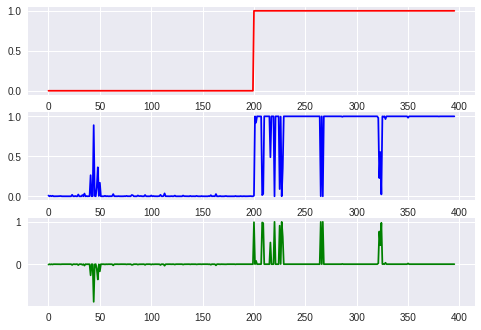

In [34]:
Y_pred = model.predict(X_test)

plt.subplot(3, 1, 1)
plt.plot(Y_test[:, 1], 'r')

plt.subplot(3, 1, 2)
plt.plot(Y_pred[:, 1], 'b')

plt.subplot(3, 1, 3)
plt.plot(Y_test[:, 1] - Y_pred[:, 1], 'g')

plt.show()

In [35]:
now = datetime.datetime.now()

# modelSaved = '{}-{}_{}_{}.h5'.format(folderNormal, folderFault, pretrainedModel, now.strftime('%m-%d-%H:%M:%S'))

modelSaved = '{}-{}_{}_{}.h5'.format('Normal', 'Fault', pretrainedModel, now.strftime('%m-%d-%H:%M:%S'))
meanSaved = 'mean_{}.npy'.format(now.strftime('%m-%d-%H:%M:%S'))
stdSaved = 'std_{}.npy'.format(now.strftime('%m-%d-%H:%M:%S'))

inputStr = input('''Save Model as '{}'? (y/n)\n'''.format(modelSaved))

if (inputStr == 'y' or inputStr == 'Y'):  
    model.save('gdrive/My Drive/Colab/Model/{}'.format(modelSaved))
    np.save('gdrive/My Drive/Colab/Model/{}'.format(meanSaved), trainMean)
    np.save('gdrive/My Drive/Colab/Model/{}'.format(stdSaved), trainStd)

Save Model as 'Normal-Fault_Xception_10-15-06:35:24.h5'? (y/n)
y
